# 0 모델 고정해서 사용하기

In [1]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import models, layers, losses, optimizers, datasets, preprocessing, utils
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Conv2D,MaxPool2D,Flatten
from tensorflow.keras.datasets import cifar10

In [8]:
# 모델 구성

def create_model():
    model = models.Sequential()
    model.add(Conv2D(32, 3, activation='relu', padding='valid', input_shape=(32, 32, 3)))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())
    model.add(Conv2D(64, 3, activation='relu', padding='valid'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    return model

In [9]:
# 모델 생성
my_model = create_model()

# 모델 요약 출력
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 15, 15, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                        

# 1. Data Centric AI 맛보기

In [10]:
# 데이터 불러오기

(x_full, y_full), (x_test, y_test) = cifar10.load_data()

# print(x_full.shape, y_full.shape)
print('전체 원본 데이터:', x_full.shape)
print('전체 원본 라벨:', y_full.shape)
print('전체 평가 데이터:', x_test.shape)
print('전체 평가 라벨:', y_test.shape)

170498071/170498071 [==============================] - 2s 0us/step
전체 원본 데이터: (50000, 32, 32, 3)
전체 원본 라벨: (50000, 1)
전체 평가 데이터: (10000, 32, 32, 3)
전체 평가 라벨: (10000, 1)


In [11]:
# 라벨값 확인

np.unique(y_full, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [12]:
# 각 라벨의 클래스명 지정

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [13]:
# labelerrors.com의 lalabelerror 인덱스 확인 및 리스트로 정리

labelerror = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191,
              5690, 1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966, 5468]

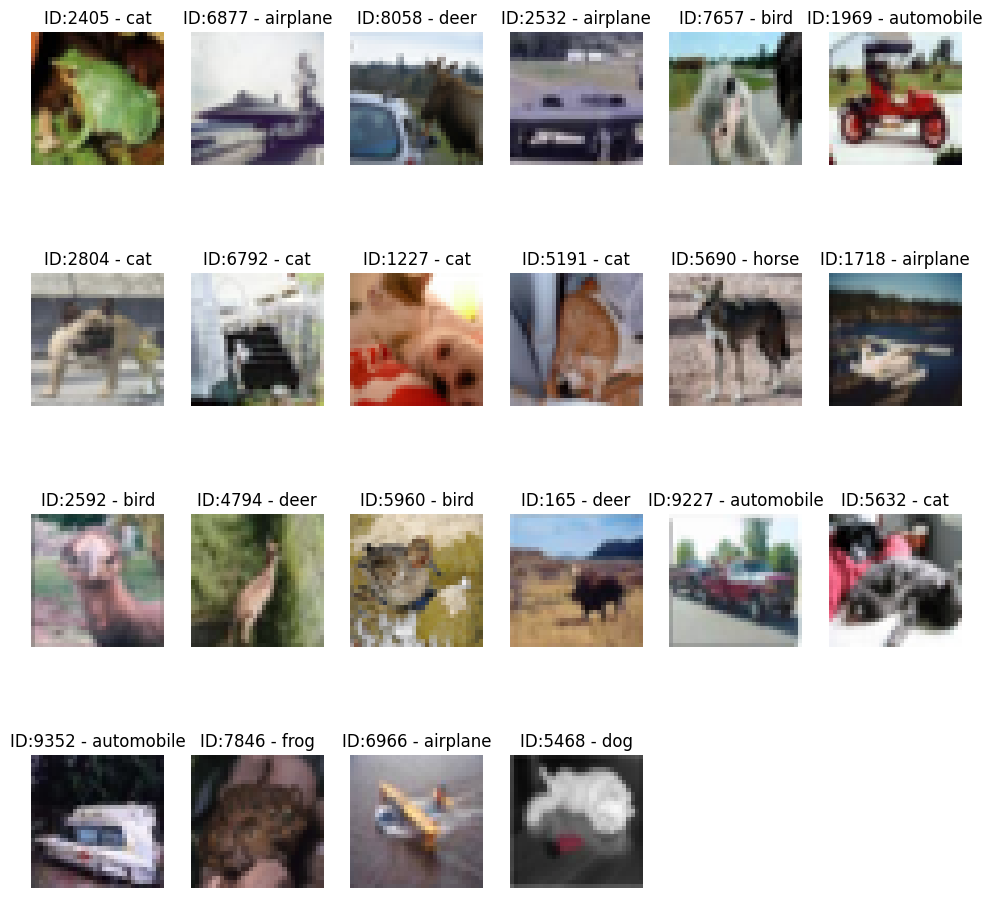

In [14]:
# lalabelerror 이미지 출력

plt.figure(figsize=(12,12))
for idx, idx_img in enumerate(labelerror):
    plt.subplot(4, 6, idx+1)
    plt.grid(False)
    plt.title(f'ID:{idx_img} - {class_names[y_test[idx_img][0]]}')
    plt.imshow(x_test[idx_img])
    plt.axis('off')
plt.show()

In [15]:
# 수정할 라벨 값 리스트로 정리

labeltrue = [6, 8, 7, 1, 7, 9, 5, 9, 5, 5, 4, 8, 4, 2, 3, 2, 9, 5, 9, 3, 8, 3]

In [16]:
# for문을 통해 lalabelerror에 있는 인덱스의 라벨값 변경

for e, t in zip(labelerror, labeltrue):
    y_test[e] = t

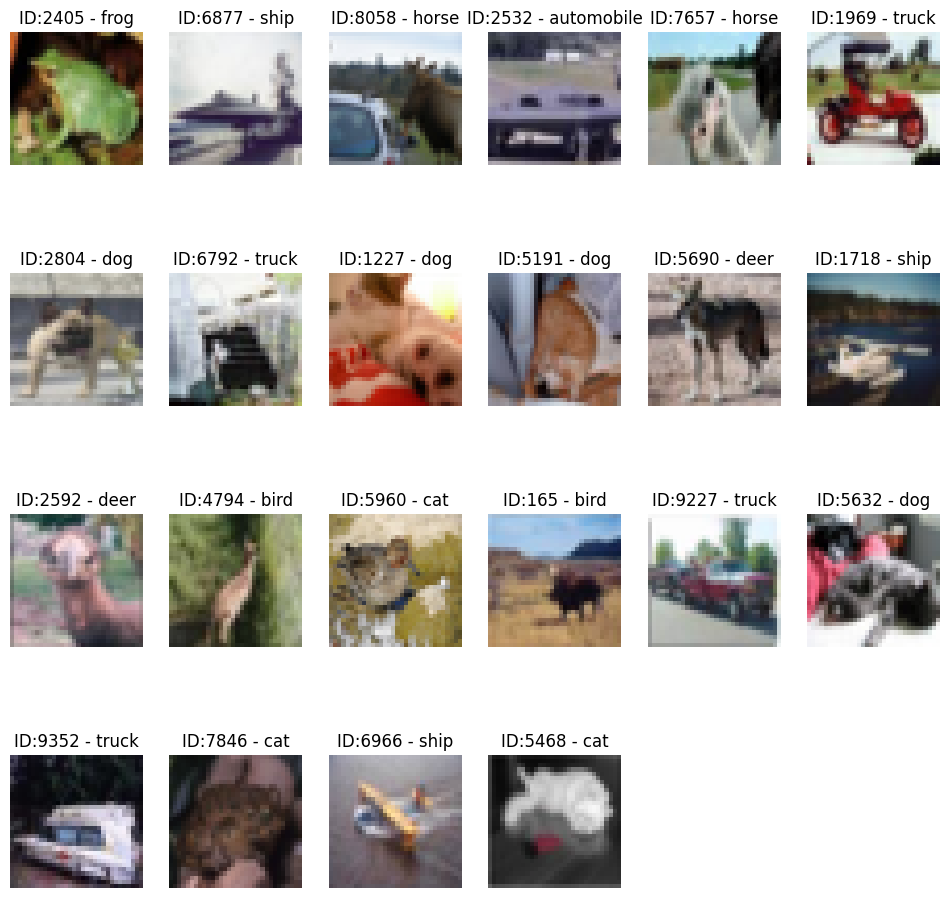

In [17]:
# 수정된 label 확인

plt.figure(figsize=(12,12))
for idx, idx_img in enumerate(labelerror):
    plt.subplot(4, 6, idx+1)
    plt.grid(False)
    plt.title(f'ID:{idx_img} - {class_names[y_test[idx_img][0]]}')
    plt.imshow(x_test[idx_img])
    plt.axis('off')
plt.show()

In [18]:
# train data와 validation data 분리

x_train, x_val, y_train, y_val = train_test_split(x_full, y_full, test_size = 0.2)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(40000, 32, 32, 3) (40000, 1)
(10000, 32, 32, 3) (10000, 1)


# 2 하이퍼파라미터 튜닝

In [19]:
# 하이퍼 파라미터 튜닝을 위한 함수 작성
# 모델은 노드에서 제시된 것처럼 고정시킴

class DeepTuner(kt.Tuner):
    def run_trial(self, trial, X, y, validation_data, **fit_kwargs):
        model = my_model
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X, y, batch_size=trial.hyperparameters.Choice('batch_size', [16, 32]), validation_data=validation_data, **fit_kwargs)

        eval_scores = model.evaluate(validation_data[0], validation_data[1])
        return {name: value for name, value in zip(model.metrics_names, eval_scores)}

In [20]:
# keras_tuner를 정의하고 탐색

my_keras_tuner = DeepTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('accuracy', 'max'),
        max_trials=10,
        seed=42),
    hypermodel=None,
    overwrite=True,
    project_name='my_keras_tuner')


my_keras_tuner.search(x_train, y_train, validation_data=(x_val, y_val), epochs=15)

Trial 2 Complete [00h 17m 27s]
accuracy: 0.7311000227928162

Best accuracy So Far: 0.7311000227928162
Total elapsed time: 00h 37m 55s


In [21]:
# 하이퍼파라미터를 불러올 모델 함수 작성

def load_model(hp):
    model = models.Sequential()
    model.add(Conv2D(hp.Int('conv1_units', min_value=32, max_value=256, step=32), 3, activation='relu', padding='valid', input_shape=(32, 32, 3)))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())
    model.add(Conv2D(hp.Int('conv2_units', min_value=32, max_value=256, step=32), 3, activation='relu', padding='valid'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=128, max_value=512, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [22]:
# 하이퍼파라미터가 적용된 모델 불러오기

best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0]
model = load_model(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 15, 15, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                      

In [23]:
# 모델 학습 및 평가

model.fit(x_train, y_train, batch_size=32, epochs = 6)
model.evaluate(x_test, y_test)

Epoch 1/6
1250/1250 [==============================] - 49s 39ms/step - loss: 1.4480 - accuracy: 0.4951
Epoch 2/6
1250/1250 [==============================] - 45s 36ms/step - loss: 1.0645 - accuracy: 0.6263
Epoch 3/6
1250/1250 [==============================] - 44s 35ms/step - loss: 0.9182 - accuracy: 0.6763
Epoch 4/6
1250/1250 [==============================] - 46s 37ms/step - loss: 0.8198 - accuracy: 0.7104
Epoch 5/6
1250/1250 [==============================] - 44s 36ms/step - loss: 0.7324 - accuracy: 0.7412
Epoch 6/6
313/313 [==============================] - 3s 10ms/step - loss: 1.0412 - accuracy: 0.6435


[1.041227102279663, 0.6434999704360962]

In [24]:
# 모델 저장

path = '/content/drive/MyDrive/mlops/model'
model.save(path)

# 4 TFLite 모델 만들기 (옵션)

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# tf.lite.TFLiteConverter메소드 활용해 tflite파일로 변환 및 서명 확인

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_model)

signatures = interpreter.get_signature_list()
print(signatures)

{'serving_default': {'inputs': ['conv2d_2_input'], 'outputs': ['dense_3']}}


In [27]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

# 회고
- MLOps의 전반적 과정이 숙지되지 않았기에 KerasTuner를 이용한 하이퍼파라미터 튜닝의 과정이 완전히 이해되지는 않음.
- 그러나, KerasTuner와 같이 최적의 하이퍼파리미터를 찾게 도와주는 도구를 적절히 사용하면 성능이 좋은 모델을 구축하는데 큰 도움이 될 것이라고 생각함.
- 프로젝트를 진행하면서 두 가지 의문이 생김. 하나는, 노드에서 제시한 것과 같이 모델을 고정한 뒤에 하이퍼파라미터 튜닝을 한다는 것이 모델을 고정하지 않은 것과는 어떤 차이를 지니는지 궁금함.
- 다른 하나는 하이퍼파라미터 튜닝 후에 두 번째 Conv2D layer와  Dense layer의 유닛 수가 바뀌었는데, 구체적으로 어떤 과정을 통해 바뀌었는지 궁금함.
- <3. 모델 배포하기 (옵션)>은 시간 관계 상 진행하지 못했음.